# Отток клиентов

### Цель проекта

На основе исторических данных о поведении клиентов и расторжении договоров в банком построить модели машинного обучения которые помогут спрогнозировать уход клиентов.
* метрика оценки модели - значение F1
* построить график AUC-ROC
* минимально приемлимое значение метрики F1 = 0.59

План работы:

* Разделить исходные данные на обучающую, валидационную и тестовую выборки в соотношении 60-20-20
* рассмотреть модель без учета дизбаланса, исследовать баланс классов
* Исследовать качество нескольких разных моделей, меняя гиперпараметры и учитывая дисбаланс классов
* Проврить качество лучшей модели на тестовой выборке.
* Проверить модель на вменяемость
* Сформулировать выводы

Признаки

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак

* Exited — факт ухода клиента

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import f1_score, r2_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

from sklearn.dummy import DummyClassifier



In [2]:
data = pd.read_csv('C:\\Users\\Freo\\Desktop\\projects\\datasets\\p6.csv')

In [3]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


подготовим данные:
колонки 'RowNumber', 'CustomerId', 'Surname' для обучения нашей модели явно не важны

In [4]:
data_preprocessed = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

посмотрим на наличие пропусков

In [5]:
data_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


нашли пропуски в столбце "стажа" пользователей, посмотрим на них

In [6]:
data_preprocessed['Tenure'].value_counts().sort_index()

Tenure
0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
Name: count, dtype: int64

<Axes: >

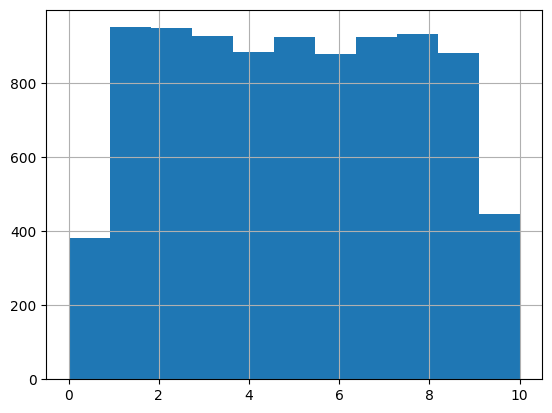

In [7]:
data_preprocessed['Tenure'].hist(bins=11)

Стаж клиентов распределен довольно равномерно по большинству годов, однако есть большой недобор по клиентам которым меньше года. Пропуски в стаже могут быть обусловлены как тем что это новые клиенты, так и совершенно не связанной с этим причиной.

На первый взгляд есть несколько вариантов что делать с этими пропусками
* попробовать найти исходные данные
* поискать корреляцию с другими признаками, сгруппировать данные по этим признакам и заполнить медианой по группам
* удалить их
* заполнить заглушкой или случайными значениям

Получилось добиться наиболее предпочтительного варианта, найдя исходные данные 

In [8]:
data = pd.read_csv('C:\\Users\\Freo\\Desktop\\projects\\datasets\\Churn_Modelling.csv')

In [9]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [10]:
data_preprocessed = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [11]:
data_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [12]:
data_preprocessed['Tenure'].value_counts().sort_index()

Tenure
0      413
1     1035
2     1048
3     1009
4      989
5     1012
6      967
7     1028
8     1025
9      984
10     490
Name: count, dtype: int64

переведем страны в числовой формат создав дополнительные колонки со значениями 1 или 0

In [13]:
data_ohe = pd.get_dummies(data_preprocessed, drop_first = True)

In [14]:
R_STATE = 12345

## Исследование задачи

Исследуем баланс классов

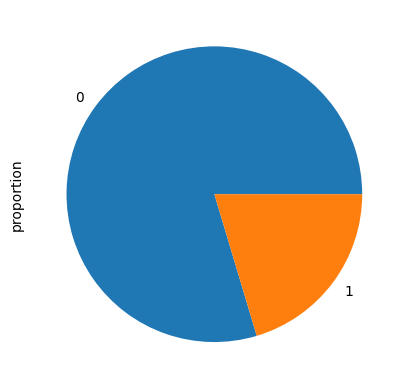

In [15]:
data['Exited'].value_counts(normalize=True).plot(kind='pie');

обучим модель без учёта дисбаланса

In [16]:
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']


features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=R_STATE)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=R_STATE)

In [17]:
model = RandomForestClassifier(random_state=R_STATE)
model.fit(features_train, target_train)

pred_valid = model.predict(features_valid)
f1_score(target_valid, pred_valid)
print('f1',f1_score(target_valid, pred_valid))
print('accuracy', accuracy_score(target_valid, pred_valid))



f1 0.5894736842105263
accuracy 0.8635


auc roc  0.840690573981212


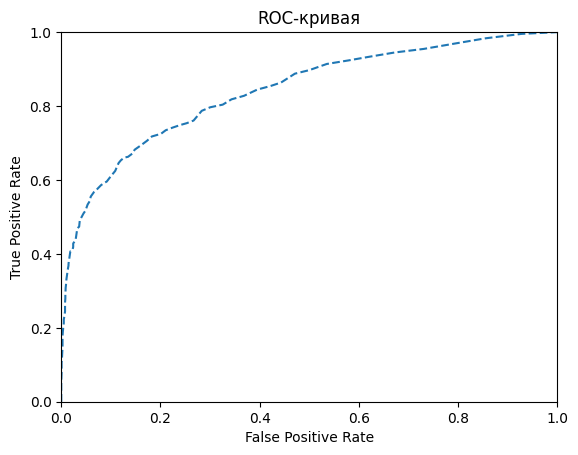

In [18]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc roc ',auc_roc)

fpr_0, tpr_0, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr_0, tpr_0, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

неплохо но до 59 немного нехватает; 

баланс классов в базе ощутимо смещен в сторону не ушедших клиентов; сбалансировав вес классов и стратифицировав выборки можно улучшить предсказательные возможности нашей модели

## Борьба с дисбалансом

Начнем улучшать качество модели со стратификации выборки

In [19]:
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']


features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=R_STATE, stratify = target)




features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=R_STATE, stratify = target_temp)

для работы с регрессиями зарание масштабируем значения столбцов

In [20]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

построим несколько моделей; добавим class_weight='balanced' для сбалансированности классов

### RF c class_weight='balanced'

In [21]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 15):
    model = RandomForestClassifier(random_state=R_STATE, max_depth = depth, class_weight='balanced')
    model.fit(features_train, target_train)
    pred_v = model.predict(features_valid)
    result = f1_score(target_valid, pred_v)

    if result > best_result:
        best_model_dt = model
        best_result = result
        best_depth = depth
print(f'f1_score лучшей модели:, {best_result}, на глубине {best_depth}')

f1_score лучшей модели:, 0.6425438596491229, на глубине 8


In [22]:
best_model = None
best_result = 0
for est in range(10, 300, 10):
    model = RandomForestClassifier(n_estimators=est, random_state=R_STATE, max_depth = best_depth, class_weight='balanced')
    model.fit(features_train, target_train)
    pred_v = model.predict(features_valid)
    result = f1_score(target_valid, pred_v)
    if result > best_result:
        best_model_dt = model
        best_result = result
        best_est = est
print(f'f1_score лучшей модели:, {best_result}, на глубине {best_depth}, est = {best_est}')

f1_score лучшей модели:, 0.6528384279475983, на глубине 8, est = 200


In [23]:
model = RandomForestClassifier(n_estimators=best_est, max_depth = best_depth, random_state=R_STATE, class_weight='balanced')
model.fit(features_train, target_train)
pred_valid = model.predict(features_valid)

print(f1_score(target_valid, pred_valid))


0.6528384279475983


In [24]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc roc',auc_roc)

fpr_rfc_balanced, tpr_rfc_balanced, thresholds = roc_curve(target_valid, probabilities_one_valid)


print('accuracy', accuracy_score(target_valid, pred_valid))

auc roc 0.8724150778401814
accuracy 0.841


### RF с изменением порога вручную

найдем новые значения глубины и количества деревьев

In [25]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 15):
    model = RandomForestClassifier(random_state=R_STATE, max_depth = depth)
    model.fit(features_train, target_train)
    pred_v = model.predict(features_valid)
    result = f1_score(target_valid, pred_v)

    if result > best_result:
        best_model_dt = model
        best_result = result
        best_depth = depth
print(f'f1_score лучшей модели:, {best_result}, на глубине {best_depth}')

f1_score лучшей модели:, 0.6128550074738416, на глубине 14


In [26]:
best_model = None
best_result = 0
for est in range(10, 300, 10):
    model = RandomForestClassifier(n_estimators=est, random_state=R_STATE, max_depth = best_depth)
    model.fit(features_train, target_train)
    pred_v = model.predict(features_valid)
    result = f1_score(target_valid, pred_v)
    if result > best_result:
        best_model_dt = model
        best_result = result
        best_est = est
print(f'f1_score лучшей модели:, {best_result}, на глубине {best_depth}, est = {best_est}')

f1_score лучшей модели:, 0.620384047267356, на глубине 14, est = 60


рассмотрим диапазоны для определения границы класса и значение f1

In [27]:
model = RandomForestClassifier(n_estimators=best_est, max_depth = best_depth, random_state=R_STATE)
model.fit(features_train, target_train)

RandomForestClassifier(max_depth=14, n_estimators=60, random_state=12345)

In [28]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_thr = 0
best_f1 = 0

for threshold in np.arange(0, 1.01, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = threshold


    print("Порог = {:.2f} | f1 = {:.6f}".format(threshold, f1))

print('best thr near', best_thr, 'best_f1', best_f1 )

Порог = 0.00 | f1 = 0.339011
Порог = 0.05 | f1 = 0.417197
Порог = 0.10 | f1 = 0.496680
Порог = 0.15 | f1 = 0.562249
Порог = 0.20 | f1 = 0.601656
Порог = 0.25 | f1 = 0.620187
Порог = 0.30 | f1 = 0.623583
Порог = 0.35 | f1 = 0.626536
Порог = 0.40 | f1 = 0.628798
Порог = 0.45 | f1 = 0.636492
Порог = 0.50 | f1 = 0.620384
Порог = 0.55 | f1 = 0.592824
Порог = 0.60 | f1 = 0.570048
Порог = 0.65 | f1 = 0.541176
Порог = 0.70 | f1 = 0.506944
Порог = 0.75 | f1 = 0.446069
Порог = 0.80 | f1 = 0.380769
Порог = 0.85 | f1 = 0.255765
Порог = 0.90 | f1 = 0.123570
Порог = 0.95 | f1 = 0.043165
Порог = 1.00 | f1 = 0.000000
best thr near 0.45 best_f1 0.6364922206506365


In [29]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_thr = 0
best_f1 = 0
for threshold in np.arange(0.40, 0.50, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = threshold


    print("Порог = {:.2f} | f1 = {:.4f}".format(threshold, f1))
print('best thr', best_thr, 'best_f1', best_f1 )

Порог = 0.40 | f1 = 0.6288
Порог = 0.41 | f1 = 0.6344
Порог = 0.42 | f1 = 0.6359
Порог = 0.43 | f1 = 0.6319
Порог = 0.44 | f1 = 0.6304
Порог = 0.45 | f1 = 0.6365
Порог = 0.46 | f1 = 0.6264
Порог = 0.47 | f1 = 0.6174
Порог = 0.48 | f1 = 0.6161
Порог = 0.49 | f1 = 0.6158
best thr 0.45000000000000007 best_f1 0.6364922206506365


In [30]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

pred_valid = probabilities_one_valid > 0.33

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc roc',auc_roc)

fpr_rfc_thr_33, tpr_rfc_thr_33, thresholds = roc_curve(target_valid, probabilities_one_valid)

print('acc s', accuracy_score(target_valid, pred_valid))

auc roc 0.8677702236673563
acc s 0.843


### LogisticRegression

In [31]:
model = LogisticRegression(random_state=R_STATE)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("f1_score:", f1_score(target_valid, predicted_valid))

f1_score: 0.31078610603290674


найдем значение порога классов

In [32]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_thr = 0
best_f1 = 0

for threshold in np.arange(0, 1.01, 0.05):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    
    if f1 > best_f1:
        best_f1 = f1
        best_thr = threshold

    print("Порог = {:.2f} | f1 = {:.4f}".format(threshold, f1))

print('best thr near', best_thr, 'best_f1', best_f1 )



Порог = 0.00 | f1 = 0.3389
Порог = 0.05 | f1 = 0.3684
Порог = 0.10 | f1 = 0.4273
Порог = 0.15 | f1 = 0.4753
Порог = 0.20 | f1 = 0.5064
Порог = 0.25 | f1 = 0.5173
Порог = 0.30 | f1 = 0.5029
Порог = 0.35 | f1 = 0.4638
Порог = 0.40 | f1 = 0.4292
Порог = 0.45 | f1 = 0.3494
Порог = 0.50 | f1 = 0.3108
Порог = 0.55 | f1 = 0.2706
Порог = 0.60 | f1 = 0.2167
Порог = 0.65 | f1 = 0.1239
Порог = 0.70 | f1 = 0.0742
Порог = 0.75 | f1 = 0.0380
Порог = 0.80 | f1 = 0.0144
Порог = 0.85 | f1 = 0.0000
Порог = 0.90 | f1 = 0.0000
Порог = 0.95 | f1 = 0.0000
Порог = 1.00 | f1 = 0.0000
best thr near 0.25 best_f1 0.5173439048562933


In [33]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_thr = 0
best_f1 = 0
for threshold in np.arange(0.2, 0.3, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = threshold

    print("Порог = {:.2f} | f1 = {:.4f}".format(threshold, f1))

print('best thr near', best_thr, 'best_f1', best_f1 )

Порог = 0.20 | f1 = 0.5064
Порог = 0.21 | f1 = 0.5122
Порог = 0.22 | f1 = 0.5240
Порог = 0.23 | f1 = 0.5247
Порог = 0.24 | f1 = 0.5278
Порог = 0.25 | f1 = 0.5173
Порог = 0.26 | f1 = 0.5180
Порог = 0.27 | f1 = 0.5207
Порог = 0.28 | f1 = 0.5215
Порог = 0.29 | f1 = 0.5205
best thr near 0.24000000000000005 best_f1 0.527831094049904


In [34]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc roc',auc_roc)

fpr_lr_thr, tpr_lr_thr, thresholds = roc_curve(target_valid, probabilities_one_valid)

pred_valid = probabilities_one_valid > 0.23
print('acc s', accuracy_score(target_valid, pred_valid))

auc roc 0.7873420410877919
acc s 0.7445


### логистическая регрессия с class_weight='balanced'

проверим лучший солвер

In [35]:
list_solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
for solv in list_solver:
    model = LogisticRegression(random_state=R_STATE, solver=solv, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(solv, "f1_score:", f1_score(target_valid, predicted_valid))

newton-cg f1_score: 0.5289982425307557
lbfgs f1_score: 0.5289982425307557
liblinear f1_score: 0.5289982425307557
sag f1_score: 0.5289982425307557
saga f1_score: 0.5289982425307557


In [36]:
model = LogisticRegression(random_state=R_STATE, solver='lbfgs', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print("f1_score:", f1_score(target_valid, predicted_valid))

f1_score: 0.5289982425307557


In [37]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('auc roc',auc_roc)

fpr_lr_balanced, tpr_lr_balanced, thresholds = roc_curve(target_valid, probabilities_one_valid)

auc roc 0.7935711030643413


модель случайного леса показала себя лучше, остановимся на ней; достаточный f1 score достигнут; теперь проверим на тестовой выборке

### Итог сравнения моделей

модель | AUC ROC | F1
---|---|---
RF без учета дизбаланса и настроек | 0.840690 | 0.589473 
**RF weight balanced** | **0.872415** | **0.652838**
RF thr45 | 0.867770 | 0.636492 
логистическая регрессия thr24| 0.787342 | 0.527831
логистическая регрессия weight balanced | 0.793571 | 0.528998 


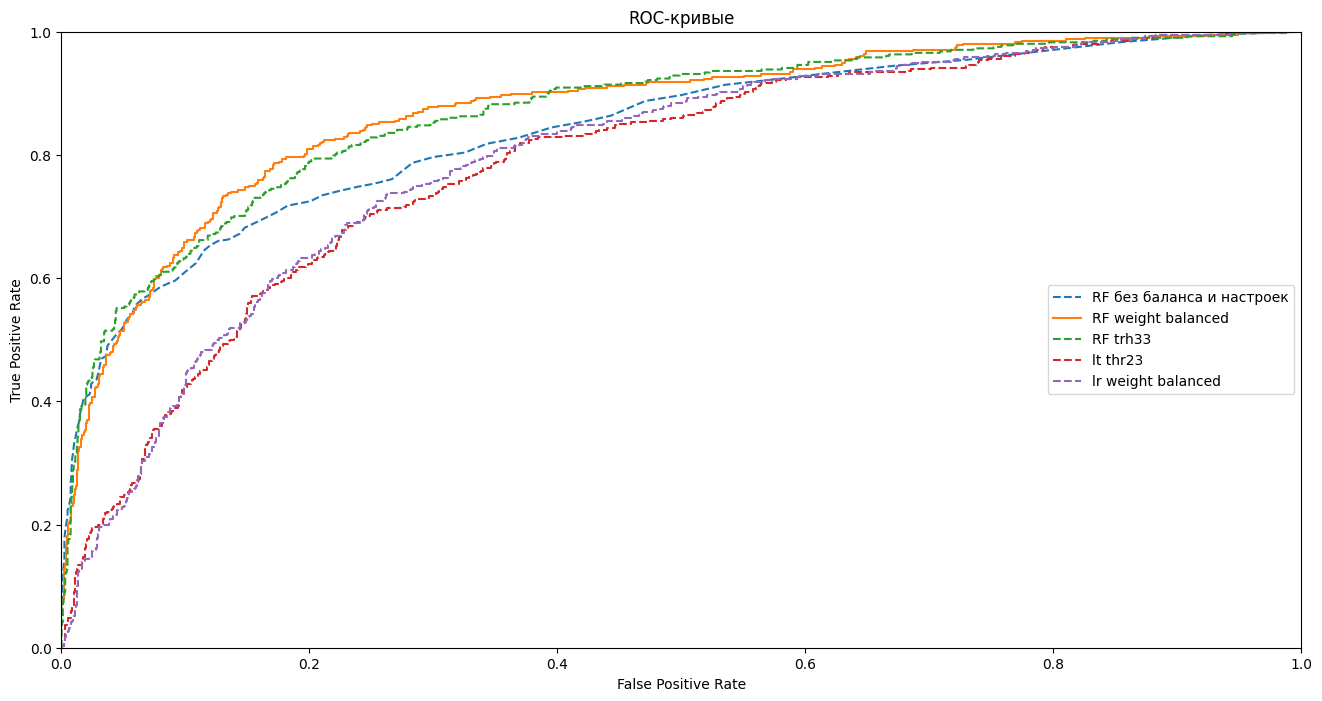

In [38]:

plt.figure(figsize=(16, 8))
plt.plot(fpr_0, tpr_0, linestyle='--',label="RF без баланса и настроек")
plt.plot(fpr_rfc_balanced, tpr_rfc_balanced, linestyle='solid',label="RF weight balanced")
plt.plot(fpr_rfc_thr_33, tpr_rfc_thr_33, linestyle='--', label="RF trh33")
plt.plot(fpr_lr_thr, tpr_lr_thr, linestyle='--',label="lt thr23")
plt.plot(fpr_lr_balanced, tpr_lr_balanced, linestyle='--',label="lr weight balanced")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc="center right")
plt.show()



лучшие результаты показала модель случайного леса с параметрами деревья=200, глубина = 8 , class_weight='balanced' на заранее стратифицированной выборке

## Тестирование модели

Обьединим тренировочную и валидационную выборки перед обучением и проверкой лучшей модели

In [39]:
features_80 =  np.concatenate((features_train, features_valid))

In [40]:
target_80 = pd.concat([target_train, target_valid])

In [41]:
model = RandomForestClassifier(n_estimators=200, max_depth = 8, random_state=R_STATE , class_weight='balanced')
model.fit(features_80, target_80)

pred_t = model.predict(features_test)
print('f1',f1_score(target_test, pred_t))
print('accuracy',accuracy_score(target_test, pred_t))

f1 0.621978021978022
accuracy 0.828


рассмотрим также метрику AUC-ROC

auc roc 0.8597071647919106


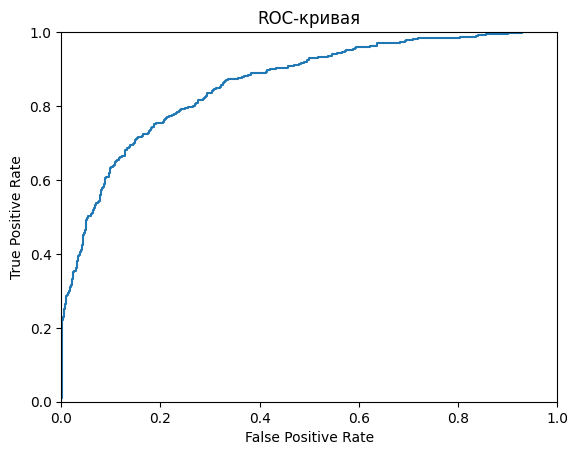

In [42]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('auc roc',auc_roc)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr, linestyle='solid')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()




Чтобы оценить адекватность модели сравним её с моделью которая выбирает самый распространный в обучающей выборке вариант:

In [43]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_80, target_80)
print('accuracy',dummy_clf.score(features_test, target_test))

accuracy 0.7965


In [44]:
pred_d_t = dummy_clf.predict(features_test)
probabilities_d_test = dummy_clf.predict_proba(features_test)
probabilities_d_one_test = probabilities_d_test[:, 1]

print('f1 dummy',f1_score(target_test, pred_d_t))
print('roc auc dummy',roc_auc_score(target_test, probabilities_d_one_test))

f1 dummy 0.0
roc auc dummy 0.5


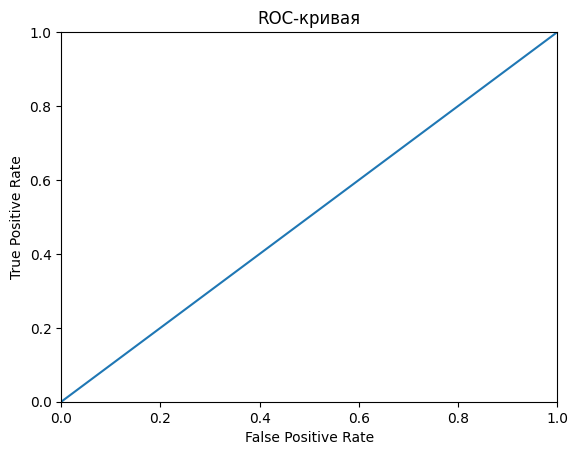

In [45]:
fpr_d, tpr_d, thresholds = roc_curve(target_test, probabilities_d_one_test)
plt.figure()
plt.plot(fpr_d, tpr_d, linestyle='solid')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

accuracy и AUC ROC нашей модели выше

### Вывод и итоги

Мы разделили данные на 3 стратифицированные выборки:
* для обучения модели
* для выбора и настройки модели
* для итоговой проверки соотвествия необходимому критерию f1.

Проверялись модели случайного леса и логистической регрессии с разными подбором гиперпараметрами и балансом весов

Наилучший результат показала модель "случайный лес" (глубина = 8, количество деревьев = 200, class_weight='balanced')

Значения на тестовой выборке получились:
* **f1 0.621978**
* **auc roc 0.859707**

После проверки на заранее подготовленной тестовой выборке удостоверились что условия (f1 > 59) были соблюдены;
Так же проверили модель на адекватность, сравнив с простановкой наиболее частых ответов (DummyClassifier);